# Imports and definition

In [ ]:
!pip install pypulseq==1.3.1 &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

In [ ]:
!wget https://github.com/MRsources/FLASHzero/archive/refs/heads/main.zip -O FLASHzero.zip &> /dev/null
!unzip FLASHzero.zip &> /dev/null
!mv FLASHzero-main/MRM2024 . &> /dev/null
!rm -rf FLASHzero.zip FLASHzero-main &> /dev/null

In [ ]:
#@title Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import MRzeroCore as mr0
import pypulseq as pp
import torch

import torch
def permvec(x) -> torch.tensor:
    permvec = torch.zeros((x,),dtype=int)
    permvec[0] = 0
    for i in range(1,int(x/2)+1):
        permvec[i*2-1] = (-i)
        if i < x/2:
            permvec[i*2] = i
    return permvec+x//2

In [ ]:
#@title Define simulate function
def simulate_brain_2D(seq_fn,pixel=False,LL=False,verbose=False):
    # %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
    sz = [128, 128]
    # (i) load a phantom object from file
    obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')

    obj_p = obj_p.interpolate(sz[0], sz[1], 1)
    obj_p.B1[:] *= 0.77 # Needed due to scanner B1
    if pixel:
      obj_test = obj_p.build()
      obj_p.T1[64,64] = 1.5
      obj_p.T2[64,64] = 0.11
      obj_p.B1[0,64,64] = 1
      obj_p.B0[64,64] = 0
      obj_p.D[64,64] = 0.84
      obj_p.T2dash[64,64] = 30*1e-3
      obj_p.PD[:] = 0
      obj_p.PD[64,64] = 1
    mask = [obj_p.PD>0]
    if verbose:
      obj_p.plot()
    # Convert Phantom into simulation data
    obj_p = obj_p.build()


    # %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot
    # Read in the sequence
    seq0 = mr0.Sequence.import_file(seq_fn)
    # Simulate the sequence
    if pixel:
      graph = mr0.compute_graph(seq0, obj_p, 10000, 1e-6)
    else:
      graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
    if LL:
      signal = mr0.execute_graph(graph, seq0, obj_p, min_emitted_signal=1, min_latent_signal=1, print_progress=False)
    else:
      signal = mr0.execute_graph(graph, seq0, obj_p, min_emitted_signal=1e-5, min_latent_signal=1e-5, print_progress=False)

    return signal

In [ ]:
#@title Simulate decay
alternative_directory_path = 'MRM2024/seq-file/unencoded/'
task1 = simulate_brain_2D(alternative_directory_path+'task1_TR_6.seq',pixel=True,verbose=False)
task2 = simulate_brain_2D(alternative_directory_path+'task2_TR_6.seq',pixel=True,verbose=False)
task3 = simulate_brain_2D(alternative_directory_path+'task3_TR_6.seq',pixel=True,verbose=False)
rfInc_50 = simulate_brain_2D(alternative_directory_path+'rfInc_50_TR_6.seq',pixel=True,verbose=False)
rfInc_84 = simulate_brain_2D(alternative_directory_path+'rfInc_84_TR_6.seq',pixel=True,verbose=False)
rfInc_117 = simulate_brain_2D(alternative_directory_path+'rfInc_117_TR_6.seq',pixel=True,verbose=False)
LL = simulate_brain_2D(alternative_directory_path+'rfInc_117_TR_6.seq',pixel=True,LL=True,verbose=False)

# Convolution

([<matplotlib.lines.Line2D at 0x7c7cb45589a0>],
 Text(0.5, 1.0, 'x-space (abs)'))

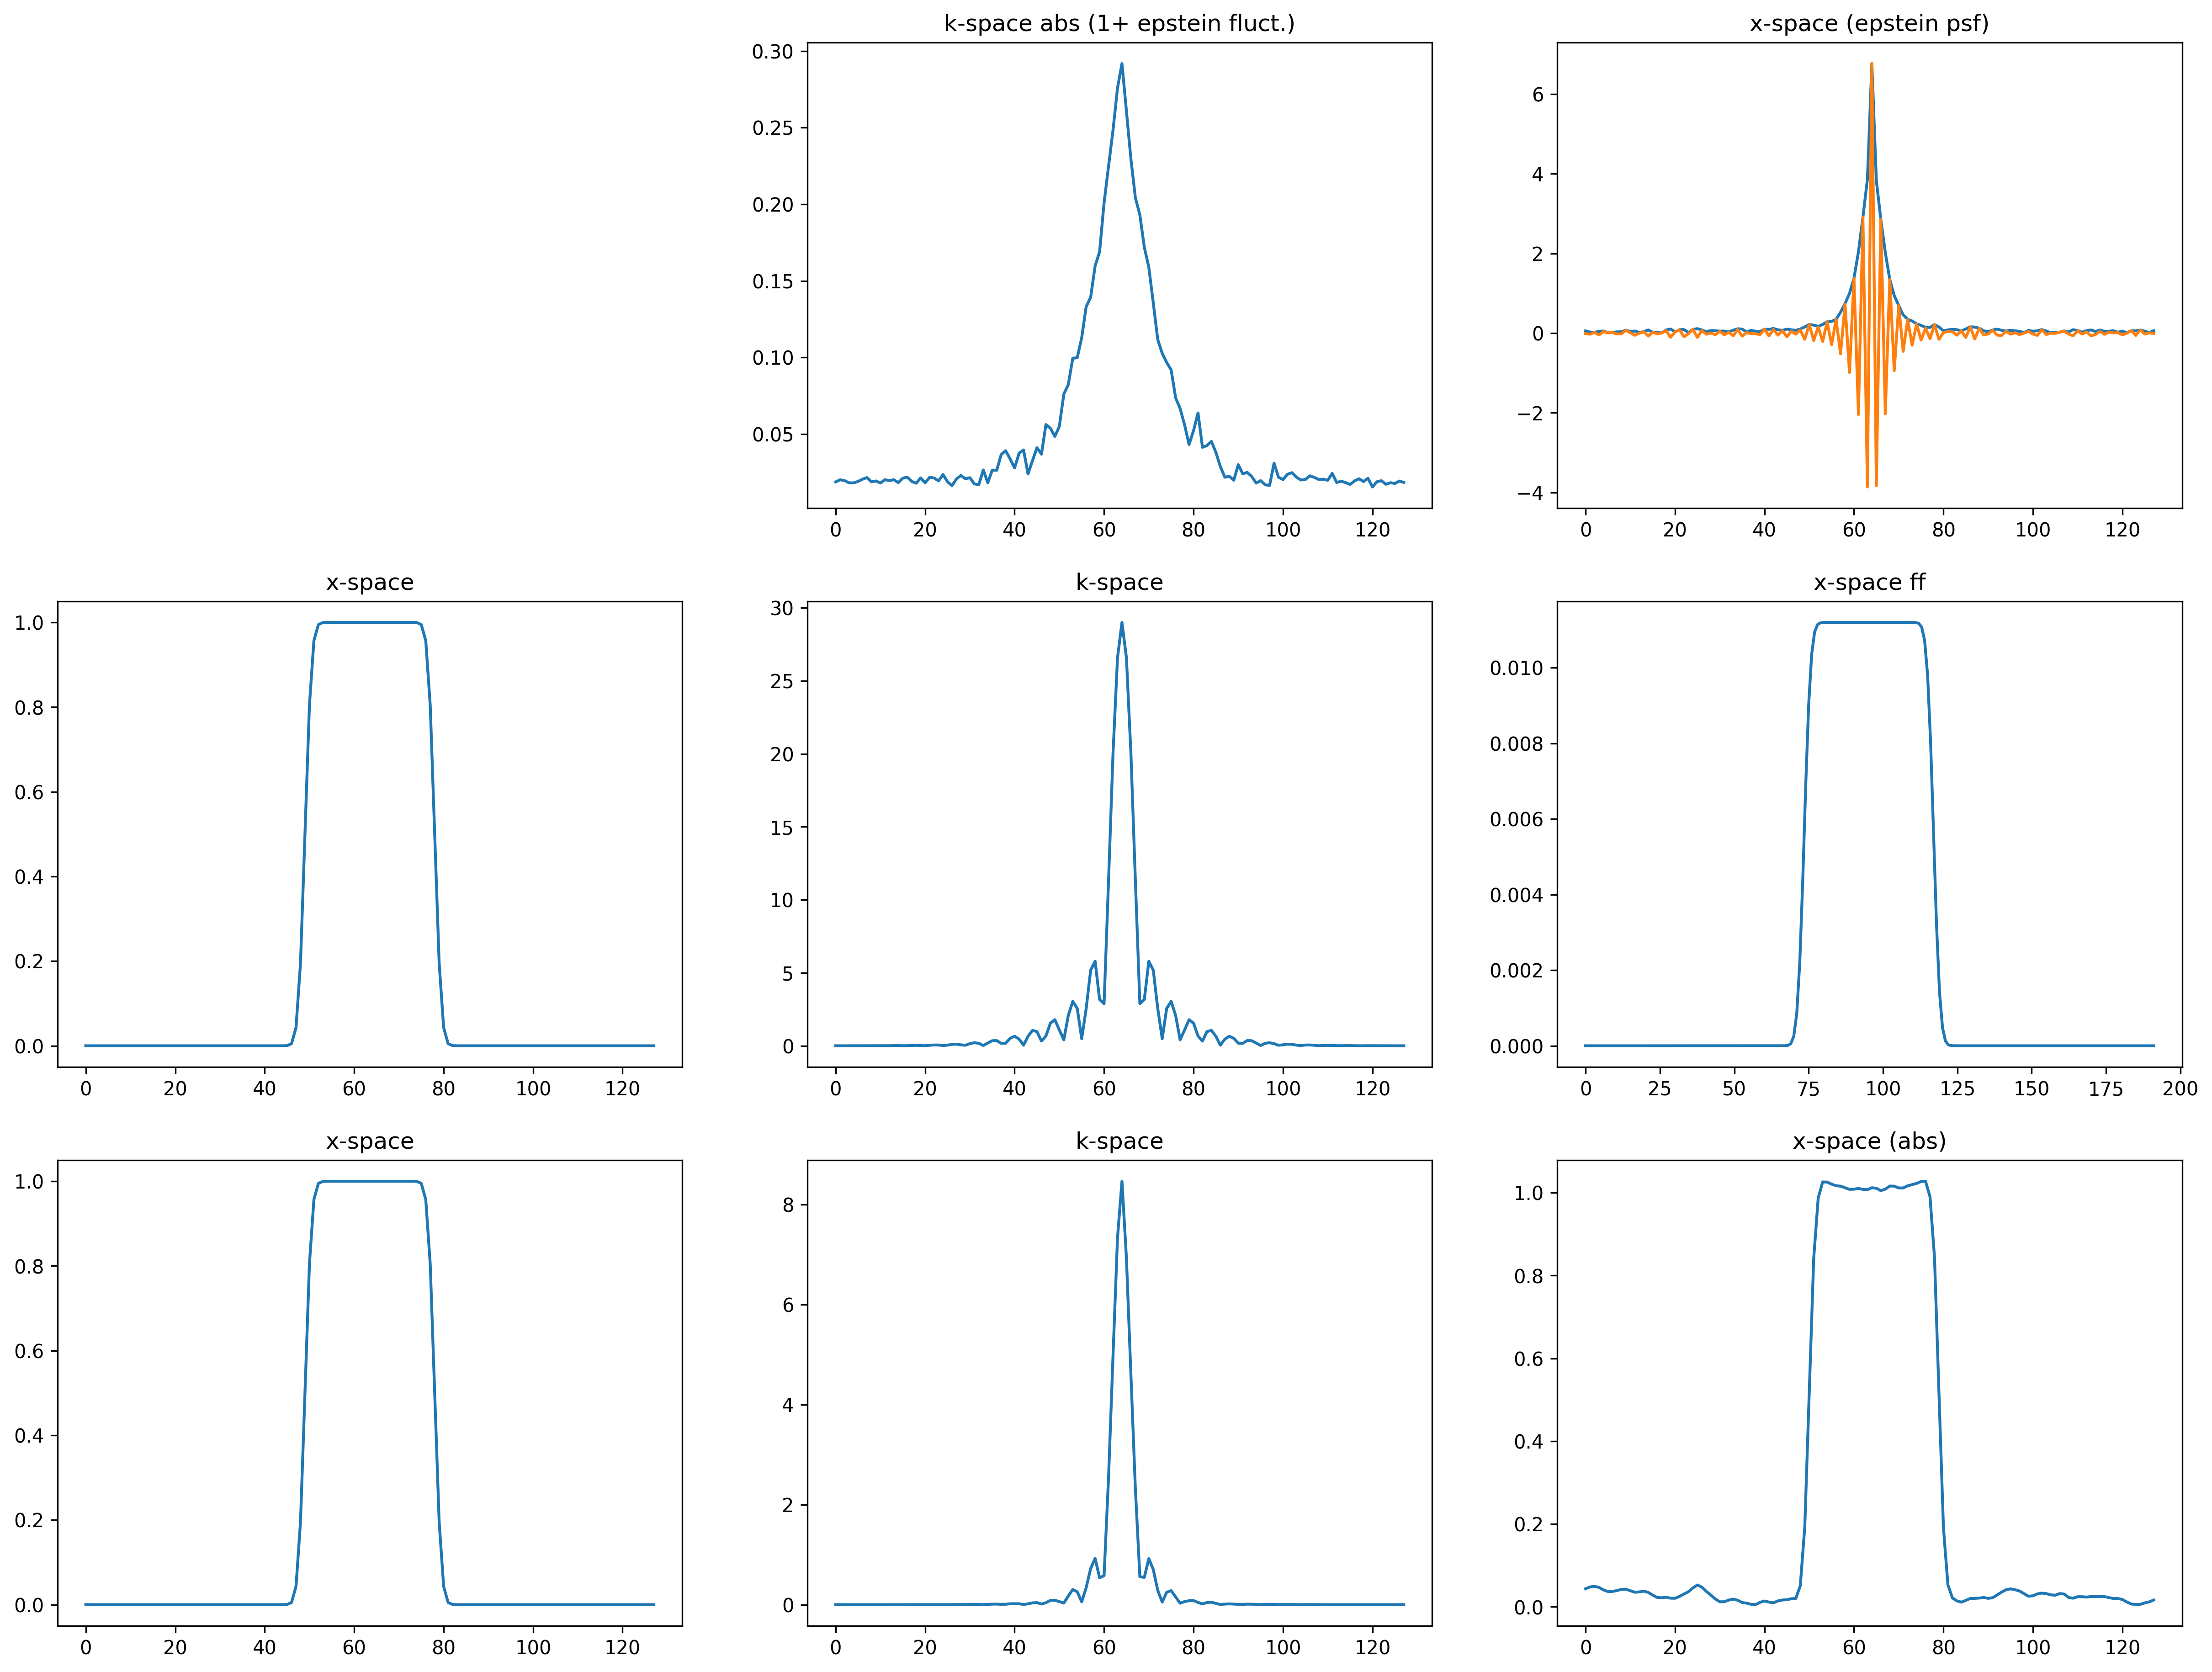

In [ ]:
#@title run convolution
#@markdown Sequence parameters:
shots = 1  # @param {type: "slider", min: 1, max: 2}

perm = permvec(128)
invperm = np.linspace(0,127,128,dtype=int)


centric = True #@param {type:"boolean"}
if centric:
  invperm = torch.argsort(perm)

# Parameters
N = 128  # Number of points
T = 1.0  # Sampling interval
k = np.linspace(0.0, N, N, endpoint=False)

#@markdown Decay parameters
# Apply damping to the sawtooth function
data = task3 # @param ["LL", "rfInc_117", "rfInc_84", "rfInc_50", "task1", "task2", "task3"] {type:"raw"}
data = data[64:128*128:128].numpy()
y_damped = np.repeat(np.array(data[invperm]),shots)

# Perform FFT on the damped signal
yf_damped = np.fft.fftshift(np.fft.fft(y_damped))
plt.figure(figsize=(20,15), dpi=300)

plt.subplot(3, 3, 2)
plt.plot(np.abs(y_damped)) , plt.title("k-space abs (1+ epstein fluct.)")

plt.subplot(3, 3, 3)
plt.plot(np.abs(yf_damped)), plt.title("x-space (epstein psf)")
plt.plot(np.real(yf_damped))
# Create rectangular functions in the frequency domain
#@markdown Object parameters:
x=np.linspace(1,128*shots,128*shots)
rect_width = 30 # @param {type: "slider", min: 1, max: 128}
rect_pos = 64 # @param {type: "slider", min: 10, max: 118}
rect = (np.abs(x-rect_pos) < rect_width / 2)
# rect = np.where(np.abs(x-rect_pos) < rect_width / 2, (x - 10) / (rect_width), 0)

from scipy.signal.windows import gaussian
window_size = 128*shots  # Adjust the size of the Gaussian kernel
gauss_width = 1.2  # @param {type: "slider", min: 0.0, max: 3.0, step: 0.1}
if gauss_width>0:
  gaussian_kernel = gaussian(window_size, std=gauss_width)
  gaussian_kernel /= np.sum(gaussian_kernel)
  rect = np.convolve(rect, gaussian_kernel, mode='same')

rectf =np.fft.fftshift(np.fft.fft(rect))

rectff= np.fft.ifft(rectf)
rectf_pad = np.pad(rectf, (0, 64))
rectf_pad /= np.linalg.norm(rectf_pad)
rectff= np.fft.ifft(rectf_pad)


plt.subplot(3, 3, 4)
plt.plot(rect), plt.title("x-space")
plt.subplot(3, 3 ,5)
plt.plot(np.abs(rectf)) , plt.title("k-space")
plt.subplot(3, 3, 6)
plt.plot(np.abs(rectff)), plt.title("x-space ff")


rectf_mult= rectf*y_damped
yf_damped /= np.sum(yf_damped)
rect_conv = np.convolve(rect, yf_damped, mode='same')

plt.subplot(3, 3, 7)
plt.plot(rect), plt.title("x-space")
plt.subplot(3, 3, 8)
plt.plot(np.abs(rectf_mult)), plt.title("k-space")
plt.subplot(3, 3, 9)
plt.plot(np.abs(rect_conv)), plt.title("x-space (abs)")